#### Import packages

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
from scipy.ndimage import distance_transform_edt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


#### Load dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Number of classes: 21
Classes: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
📊 Pascal VOC 2007 Class Mapping:
 0 → background
 1 → aeroplane
 2 → bicycle
 3 → bird
 4 → boat
 5 → bottle
 6 → bus
 7 → car
 8 → cat
 9 → chair
10 → cow
11 → diningtable
12 → dog
13 → horse
14 → motorbike
15 → person
16 → pottedplant
17 → sheep
18 → sofa
19 → train
20 → tvmonitor
Train samples: 209
Validation samples: 213
Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


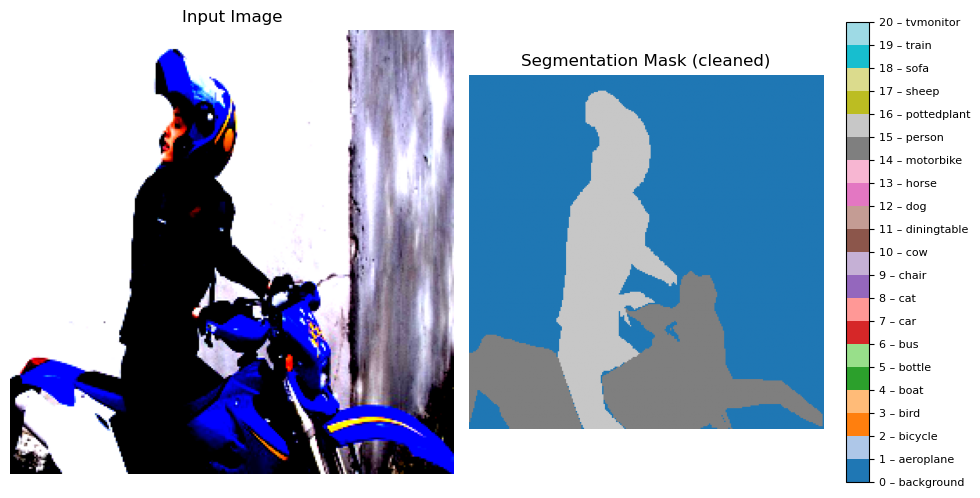

Classes in this mask: [  0  14  15 255]


In [55]:
# Define the 21 classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", 
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print("Number of classes:", NUM_CLASSES)
print("Classes:", VOC_CLASSES)

# Class mapping dictionary
class_mapping = {i: cls for i, cls in enumerate(VOC_CLASSES)}
print("📊 Pascal VOC 2007 Class Mapping:")
for idx, name in class_mapping.items():
    print(f"{idx:2d} → {name}")

# Define transforms for the images
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),           # resize for speed
    transforms.ToTensor(),                   # convert to tensor (C,H,W)
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_target = transforms.Compose([
    transforms.Resize((256, 256)),           # resize mask too
    transforms.PILToTensor()                 # keep as tensor (H,W),
])

# Load the Pascal VOC 2007 Segmentation Dataset
train_dataset = VOCSegmentation(
    root="datasets/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="train",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)
val_dataset = VOCSegmentation(
    root="datasets/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_target
)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Inspect a single batch (inputs/outputs)
images, mask = next(iter(train_loader))
print("Image batch shape:", images.shape)    # (B, 3, 256, 256)
print("Mask batch shape:", mask.shape)      # (B, 1, 256, 256)

# Visualize one image and mask
def show_sample(img, mask):
    img = img.permute(1, 2, 0).numpy()      # C,H,W -> H,W,C
    mask = mask.squeeze().numpy().copy()    # 1,H,W -> H,W
    # Clean mask: convert all values > 20 (like 255) to 0 for visualization
    mask[mask > 20] = 0
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    seg_map = plt.imshow(mask, cmap="tab20", vmin=0, vmax=20)
    plt.title("Segmentation Mask (cleaned)")
    plt.axis("off")
    # ✅ Custom colorbar with class numbers and names
    cbar = plt.colorbar(seg_map, ticks=range(21))
    tick_labels = [f"{i} – {VOC_CLASSES[i]}" for i in range(21)]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=8)  # smaller font if needed
    plt.tight_layout()
    plt.show()

# Show first sample
show_sample(images[0], mask[0])
print("Classes in this mask:", np.unique(mask[0].numpy()))

#### Define helper functions for model evaluation

In [26]:
def compute_confusion_matrix(y_pred, y_true, num_classes):
    k = (y_true >= 0) & (y_true < num_classes)
    y_pred = y_pred[k]
    y_true = y_true[k]
    idx = y_true * num_classes + y_pred
    cm = torch.bincount(idx, minlength=num_classes * num_classes)
    cm = cm.reshape(num_classes, num_classes)
    return cm

def compute_metrics(cm):
    cm = cm.double()
    tp = cm.diag()
    sum_row = cm.sum(dim=1)
    sum_col = cm.sum(dim=0)
    union = sum_row + sum_col - tp
    iou = tp / (union + 1e-7)
    dice = 2 * tp / (sum_row + sum_col + 1e-7)
    acc = tp / (sum_row + 1e-7)
    mean_iou = iou.mean().item()
    mean_dice = dice.mean().item()
    pixel_acc = tp.sum().item() / (cm.sum().item() + 1e-7)
    metrics = {
        "mean_iou": mean_iou,
        "mean_dice": mean_dice,
        "pixel_accuracy": pixel_acc,
        "per_class_iou": iou.cpu().numpy(),
        "per_class_acc": acc.cpu().numpy(),
        "per_class_dice": dice.cpu().numpy(),
    }
    return metrics

def compute_hd95(true_bin, pred_bin):
    true_bin = true_bin.astype(bool)
    pred_bin = pred_bin.astype(bool)
    if not true_bin.any() and not pred_bin.any():
        return 0.0
    if not true_bin.any() or not pred_bin.any():
        return 256.0
    true_distance = distance_transform_edt(~true_bin)
    pred_distance = distance_transform_edt(~pred_bin)
    true_border = true_bin ^ (distance_transform_edt(true_bin) > 0)
    pred_border = pred_bin ^ (distance_transform_edt(pred_bin) > 0)
    true_to_pred = pred_distance[true_border]
    pred_to_true = true_distance[pred_border]
    all_distances = np.concatenate([true_to_pred, pred_to_true])
    if all_distances.size == 0:
        return 0.0
    return np.percentile(all_distances, 95)

def compute_iou(pred_array, true_array, class_idx):
    valid = true_array != 255
    pred_array = pred_array[valid]
    true_array = true_array[valid]
    pred_pos = pred_array == class_idx
    true_pos = true_array == class_idx
    intersection = np.logical_and(pred_pos, true_pos).sum()
    union = np.logical_or(pred_pos, true_pos).sum()
    if union == 0:
        return 0.0
    return intersection / union

def segmentation_map(images_list, true_list, pred_list, model_name="Model"):
    n = len(images_list)
    plt.figure(figsize=(9, 3 * n))
    for i in range(n):
        img = images_list[i].permute(1, 2, 0).cpu().numpy()
        y_true = true_list[i]
        y_pred = pred_list[i]
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(img)
        plt.title("input")
        plt.axis("off")
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(y_true, cmap="tab20", vmin=0, vmax=20)
        plt.title("truth")
        plt.axis("off")
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(y_pred, cmap="tab20", vmin=0, vmax=20)
        plt.title(model_name + " prediction")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

#### Implement U-Net model

Model training

In [28]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes, base_channels=64):
        super().__init__()
        self.encoder1 = DoubleConv(3, base_channels)
        self.encoder2 = DoubleConv(base_channels, base_channels * 2)
        self.encoder3 = DoubleConv(base_channels * 2, base_channels * 4)
        self.encoder4 = DoubleConv(base_channels * 4, base_channels * 8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 16)
        self.up4 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, 2, stride=2)
        self.decoder4 = DoubleConv(base_channels * 16, base_channels * 8)
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.decoder3 = DoubleConv(base_channels * 8, base_channels * 4)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.decoder2 = DoubleConv(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.decoder1 = DoubleConv(base_channels * 2, base_channels)
        self.out_conv = nn.Conv2d(base_channels, NUM_CLASSES, kernel_size=1)
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.decoder4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)
        out = self.out_conv(d1)
        return out

unet_model = UNet(num_classes=NUM_CLASSES, base_channels=64).to(device)
unet_optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
unet_loss_func = nn.CrossEntropyLoss(ignore_index=255)
for epoch in range(15):
    unet_model.train()
    unet_total_loss = 0.0
    print(f"Epoch {epoch+1}")
    for images_batch, masks_batch in tqdm(train_loader):
        images_batch = images_batch.to(device)
        masks_batch = masks_batch.squeeze(1).to(device).long()
        unet_optimizer.zero_grad()
        unet_loss = unet_loss_func(unet_model(images_batch), masks_batch)
        unet_loss.backward()
        unet_optimizer.step()
        unet_total_loss += unet_loss.item() * images_batch.size(0)
    unet_avg_loss = unet_total_loss / len(train_loader.dataset)
    print(f"U-Net epoch {epoch+1}: train loss = {unet_avg_loss:.4f}")

Epoch 1


100%|██████████| 52/52 [13:13<00:00, 15.26s/it]


U-Net epoch 1: train loss = 2.1171
Epoch 2


100%|██████████| 52/52 [13:08<00:00, 15.17s/it]


U-Net epoch 2: train loss = 1.3824
Epoch 3


100%|██████████| 52/52 [13:16<00:00, 15.32s/it]


U-Net epoch 3: train loss = 1.2817
Epoch 4


100%|██████████| 52/52 [14:05<00:00, 16.27s/it]


U-Net epoch 4: train loss = 1.2410
Epoch 5


100%|██████████| 52/52 [15:07<00:00, 17.46s/it]


U-Net epoch 5: train loss = 1.2473
Epoch 6


100%|██████████| 52/52 [14:35<00:00, 16.85s/it]


U-Net epoch 6: train loss = 1.2258
Epoch 7


100%|██████████| 52/52 [13:50<00:00, 15.96s/it]


U-Net epoch 7: train loss = 1.2417
Epoch 8


100%|██████████| 52/52 [15:07<00:00, 17.45s/it]


U-Net epoch 8: train loss = 1.2396
Epoch 9


100%|██████████| 52/52 [12:44<00:00, 14.69s/it]


U-Net epoch 9: train loss = 1.2135
Epoch 10


100%|██████████| 52/52 [12:55<00:00, 14.92s/it]


U-Net epoch 10: train loss = 1.2055
Epoch 11


100%|██████████| 52/52 [13:23<00:00, 15.44s/it]


U-Net epoch 11: train loss = 1.1939
Epoch 12


100%|██████████| 52/52 [13:29<00:00, 15.57s/it]


U-Net epoch 12: train loss = 1.1914
Epoch 13


100%|██████████| 52/52 [13:37<00:00, 15.73s/it]


U-Net epoch 13: train loss = 1.2002
Epoch 14


100%|██████████| 52/52 [13:22<00:00, 15.43s/it]


U-Net epoch 14: train loss = 1.1738
Epoch 15


100%|██████████| 52/52 [13:21<00:00, 15.42s/it]

U-Net epoch 15: train loss = 1.1691


Model evaluation

U-Net mIoU: 0.04309366106249001
U-Net Dice: 0.053794490955017836
U-Net Pixel accuracy: 0.7364858733169789
U-Net HD95: 86.53521126760563
U-Net Per-class IoU and accuracy
0 background IoU: 0.7449960567189249 Accuracy: 0.9776565424276056
1 aeroplane IoU: 0.0 Accuracy: 0.0
2 bicycle IoU: 0.0 Accuracy: 0.0
3 bird IoU: 0.0 Accuracy: 0.0
4 boat IoU: 0.0 Accuracy: 0.0
5 bottle IoU: 0.0 Accuracy: 0.0
6 bus IoU: 0.0 Accuracy: 0.0
7 car IoU: 0.0 Accuracy: 0.0
8 cat IoU: 0.0 Accuracy: 0.0
9 chair IoU: 0.0 Accuracy: 0.0
10 cow IoU: 0.0 Accuracy: 0.0
11 diningtable IoU: 0.0 Accuracy: 0.0
12 dog IoU: 0.0 Accuracy: 0.0
13 horse IoU: 0.0 Accuracy: 0.0
14 motorbike IoU: 0.0 Accuracy: 0.0
15 person IoU: 0.15997082559336545 Accuracy: 0.24869370002110217
16 pottedplant IoU: 0.0 Accuracy: 0.0
17 sheep IoU: 0.0 Accuracy: 0.0
18 sofa IoU: 0.0 Accuracy: 0.0
19 train IoU: 0.0 Accuracy: 0.0
20 tvmonitor IoU: 0.0 Accuracy: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


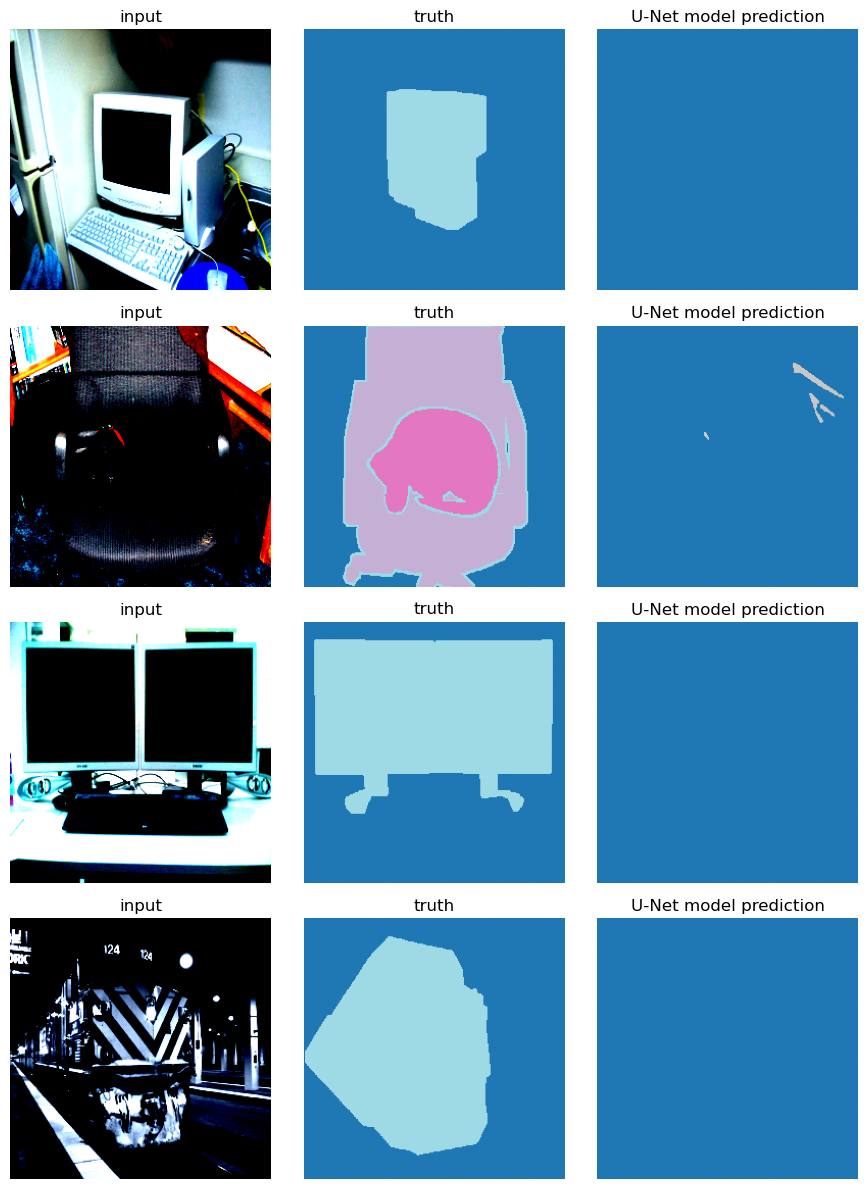

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


U-Net best IoU person: [0.65290659 0.54615099 0.53622748]
U-Net worst IoU person: [0. 0. 0.]
U-Net best person examples


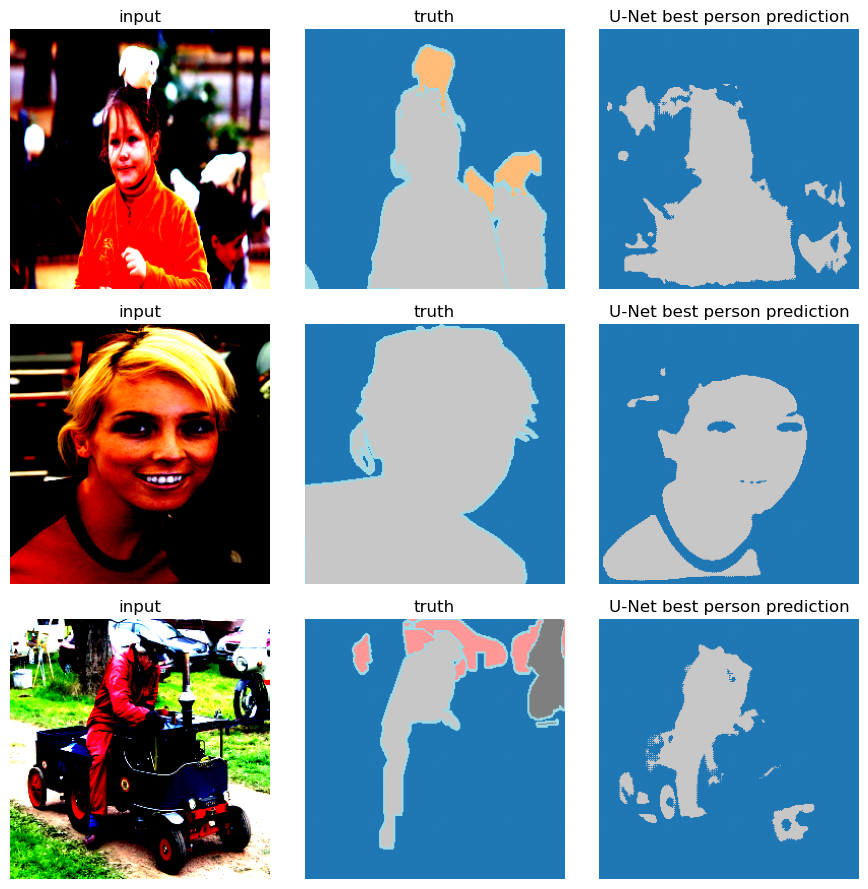

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4110641].


U-Net worst person examples


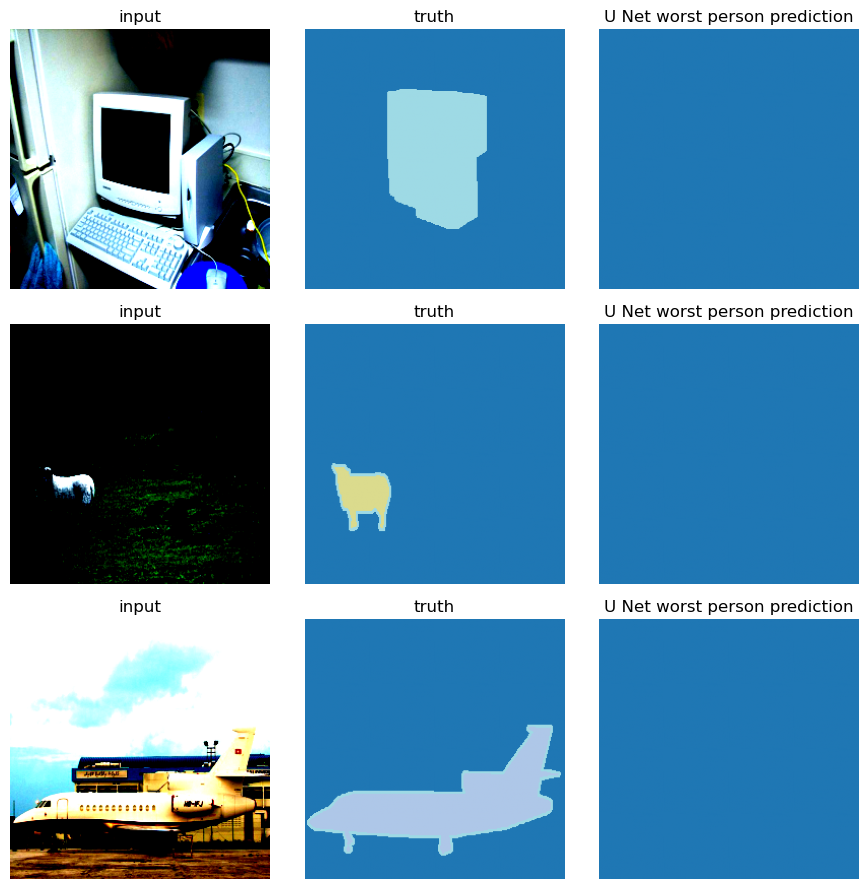

In [29]:
unet_model.eval()
unet_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64, device=device)
unet_hd95 = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_unet = masks_batch.squeeze(1).to(device).long()
        y_pred_unet = torch.argmax(unet_model(images_batch), dim = 1)
        unet_cm += compute_confusion_matrix(
            y_pred_unet[y_true_unet != 255], y_true_unet[y_true_unet != 255], NUM_CLASSES
        )
        for b in range(images_batch.size(0)):
            true_np = y_true_unet[b].cpu().numpy()
            pred_np = y_pred_unet[b].cpu().numpy()
            true_foreground = (true_np != 0) & (true_np != 255)
            pred_foreground = pred_np != 0
            hd = compute_hd95(true_foreground, pred_foreground)
            unet_hd95.append(hd)
unet_metrics = compute_metrics(unet_cm)
print("U-Net mIoU:", unet_metrics["mean_iou"])
print("U-Net Dice:", unet_metrics["mean_dice"])
print("U-Net Pixel accuracy:", unet_metrics["pixel_accuracy"])
print("U-Net HD95:", float(np.mean(unet_hd95)))
print("U-Net Per-class IoU and accuracy")
for i in range(NUM_CLASSES):
    print(
        i,
        VOC_CLASSES[i],
        "IoU:",
        float(unet_metrics["per_class_iou"][i]),
        "Accuracy:",
        float(unet_metrics["per_class_acc"][i]),
    )
unet_imgs = []
unet_true = []
unet_pred = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_unet = masks_batch.squeeze(1)
        y_pred_unet = torch.argmax(unet_model(images_batch), dim=1).cpu().numpy()
        for i in range(images_batch.size(0)):
            if len(unet_imgs) >= 4:
                break
            unet_imgs.append(images_batch[i].cpu())
            unet_true.append(y_true_unet[i].numpy())
            unet_pred.append(y_pred_unet[i])
        if len(unet_imgs) >= 4:
            break
segmentation_map(unet_imgs, unet_true, unet_pred, "U-Net model")
person_idx = VOC_CLASSES.index("person")
unet_score_person = []
unet_store_person = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_unet = masks_batch.squeeze(1)
        y_pred_unet = torch.argmax(unet_model(images_batch), dim=1).cpu().numpy()
        for i in range(images_batch.size(0)):
            true_array = y_true_unet[i].numpy()
            pred_array = y_pred_unet[i]
            iou_person = compute_iou(pred_array, true_array, person_idx)
            unet_score_person.append(iou_person)
            unet_store_person.append((images_batch[i].cpu(), true_array, pred_array))
unet_score_person = np.array(unet_score_person)
order = np.argsort(unet_score_person)
print("U-Net best IoU person:", unet_score_person[order[::-1][:3]])
print("U-Net worst IoU person:", unet_score_person[order[:3]])
best_imgs = []
best_true = []
best_pred = []
for idx in order[::-1][:3]:
    img, true_array, pred_array = unet_store_person[idx]
    best_imgs.append(img)
    best_true.append(true_array)
    best_pred.append(pred_array)
worst_imgs = []
worst_true = []
worst_pred = []
for idx in order[:3]:
    img, true_array, pred_array = unet_store_person[idx]
    worst_imgs.append(img)
    worst_true.append(true_array)
    worst_pred.append(pred_array)
print("U-Net best person examples")
segmentation_map(best_imgs, best_true, best_pred, "U-Net best person")
print("U-Net worst person examples")
segmentation_map(worst_imgs, worst_true, worst_pred, "U Net worst person")

#### Implement DeepLabV3

Model training

In [30]:
deeplab_model = models.segmentation.deeplabv3_resnet50(
    weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
)
deeplab_model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size = 1)
deeplab_model.to(device)
deeplab_optimizer = torch.optim.Adam(deeplab_model.parameters(), lr = 1e-4)
deeplab_loss_func = nn.CrossEntropyLoss(ignore_index=255)
for epoch in range(10):
    deeplab_model.train()
    deeplab_total_loss = 0.0
    print(f"Epoch {epoch+1}")
    for images_batch, masks_batch in tqdm(train_loader):
        images_batch = images_batch.to(device)
        masks_batch = masks_batch.squeeze(1).to(device).long()
        deeplab_optimizer.zero_grad()
        deeplab_loss = deeplab_loss_func(deeplab_model(images_batch)["out"], masks_batch)
        deeplab_loss.backward()
        deeplab_optimizer.step()
        deeplab_total_loss += deeplab_loss.item() * images_batch.size(0)
    deeplab_avg_loss = deeplab_total_loss / len(train_loader.dataset)
    print(f"DeepLab epoch {epoch+1}: train loss = {deeplab_avg_loss:.4f}")

Epoch 1


100%|██████████| 52/52 [11:32<00:00, 13.33s/it]


DeepLab epoch 1: train loss = 2.1597
Epoch 2


100%|██████████| 52/52 [11:54<00:00, 13.74s/it]


DeepLab epoch 2: train loss = 1.3974
Epoch 3


100%|██████████| 52/52 [11:47<00:00, 13.61s/it]


DeepLab epoch 3: train loss = 1.1286
Epoch 4


100%|██████████| 52/52 [11:41<00:00, 13.49s/it]


DeepLab epoch 4: train loss = 0.9475
Epoch 5


100%|██████████| 52/52 [11:50<00:00, 13.67s/it]


DeepLab epoch 5: train loss = 0.7911
Epoch 6


100%|██████████| 52/52 [11:55<00:00, 13.75s/it]


DeepLab epoch 6: train loss = 0.7014
Epoch 7


100%|██████████| 52/52 [11:40<00:00, 13.47s/it]


DeepLab epoch 7: train loss = 0.5929
Epoch 8


100%|██████████| 52/52 [11:50<00:00, 13.67s/it]


DeepLab epoch 8: train loss = 0.5156
Epoch 9


100%|██████████| 52/52 [12:07<00:00, 13.99s/it]


DeepLab epoch 9: train loss = 0.4464
Epoch 10


100%|██████████| 52/52 [12:03<00:00, 13.91s/it]

DeepLab epoch 10: train loss = 0.4082


Model evaluation

DeepLab mIoU: 0.45447764081807207
DeepLab Dice: 0.5767416813164817
DeepLab Pixel accuracy: 0.8793733948661234
DeepLab HD95: 8.413145539906104
DeepLab Per-class IoU and accuracy
0 background IoU: 0.9003984679874258 Accuracy: 0.9614569444614238
1 aeroplane IoU: 0.6156425239666224 Accuracy: 0.6888656189700955
2 bicycle IoU: 0.14591401744129193 Accuracy: 0.1820488754469286
3 bird IoU: 0.6033147655239123 Accuracy: 0.869468589099022
4 boat IoU: 0.4210697008183278 Accuracy: 0.5194631991322506
5 bottle IoU: 0.5311542263957846 Accuracy: 0.6481827778605819
6 bus IoU: 0.7969711603045553 Accuracy: 0.9598609410525801
7 car IoU: 0.6441448351022128 Accuracy: 0.8069889754214554
8 cat IoU: 0.7797693851658498 Accuracy: 0.8522878923005044
9 chair IoU: 0.062062262811960395 Accuracy: 0.06771929233922962
10 cow IoU: 0.5546674363695503 Accuracy: 0.6407307981664723
11 diningtable IoU: 0.46678343233013975 Accuracy: 0.5695178766572268
12 dog IoU: 0.2978529429840617 Accuracy: 0.8133199071347064
13 horse IoU: 0.4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


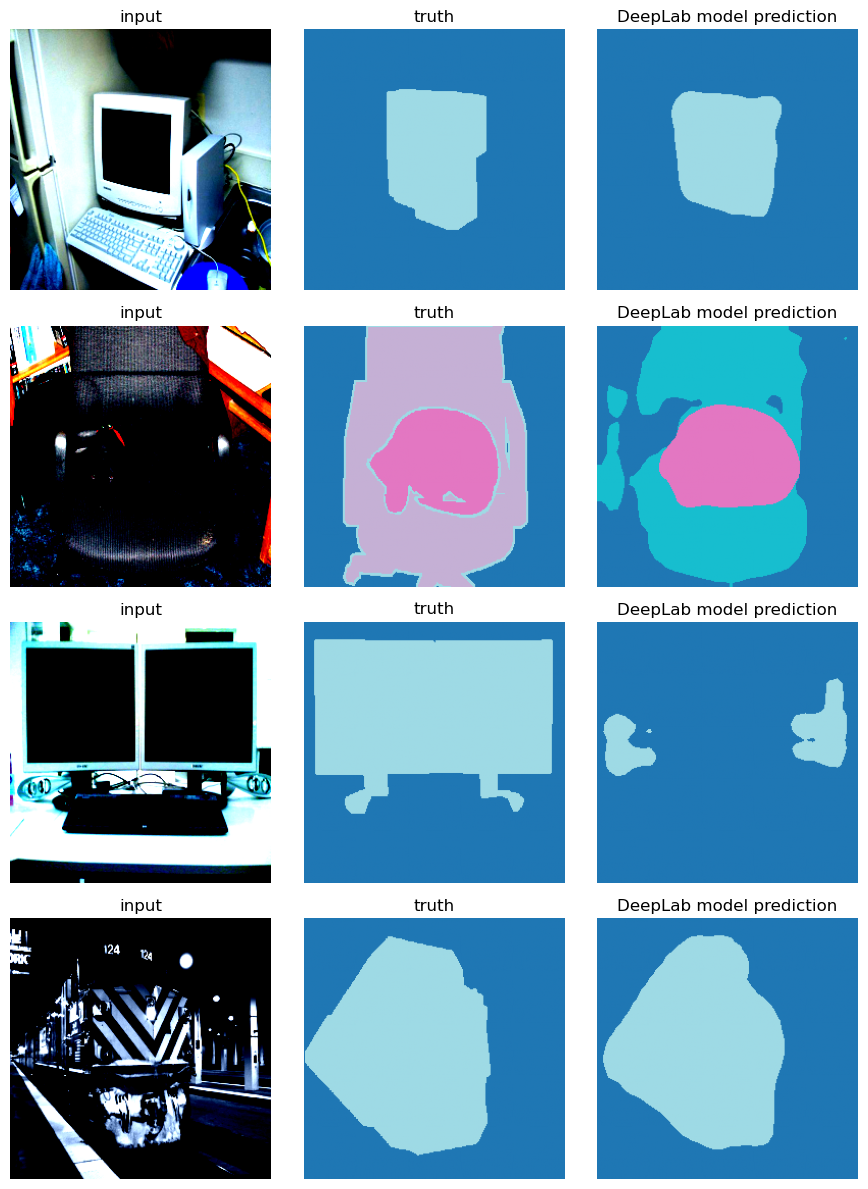

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2146587].


DeepLab best IoU person: [0.97824206 0.95242836 0.94456937]
DeepLab worst IoU person: [0. 0. 0.]
DeepLab best person examples


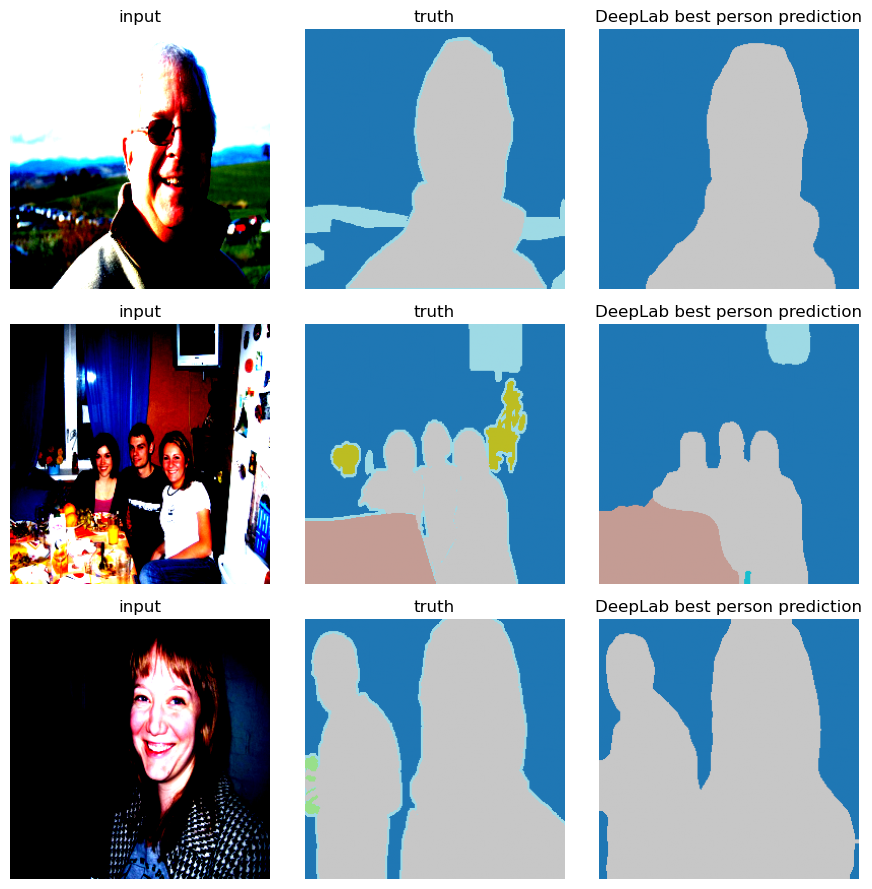

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


DeepLab worst person examples


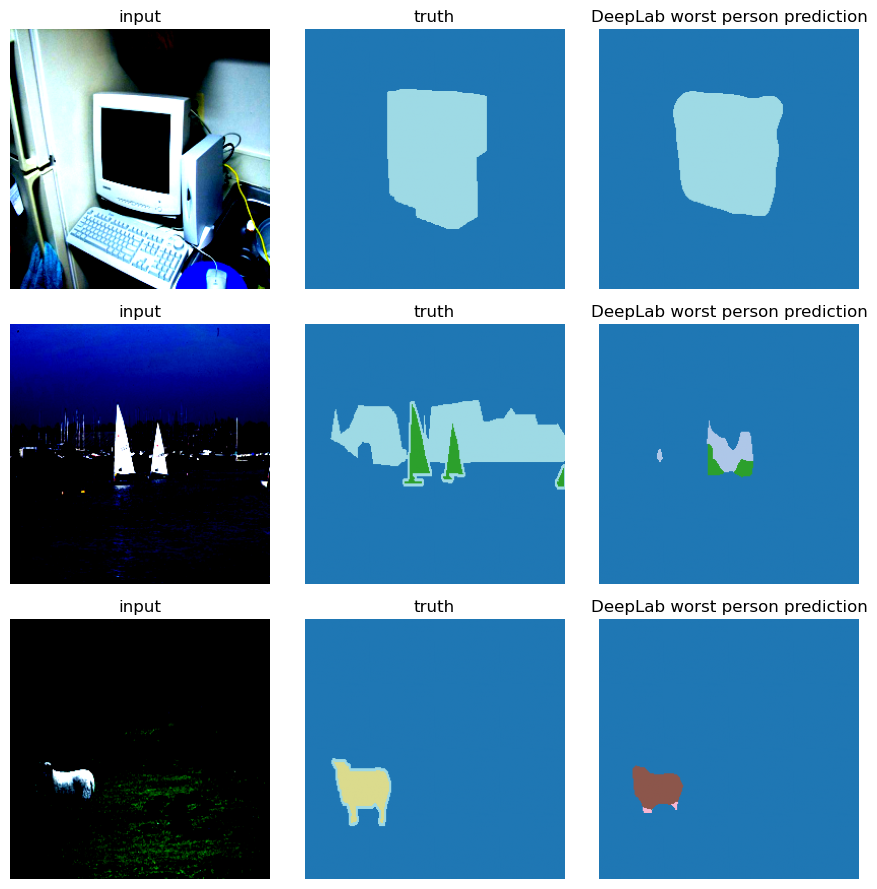

In [31]:
deeplab_model.eval()
deeplab_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64, device=device)
deeplab_hd95 = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_deeplab = masks_batch.squeeze(1).to(device).long()
        y_pred_deeplab = torch.argmax(deeplab_model(images_batch)["out"], dim = 1)
        deeplab_cm += compute_confusion_matrix(
            y_pred_deeplab[y_true_deeplab != 255], y_true_deeplab[y_true_deeplab != 255], NUM_CLASSES
        )
        for b in range(images_batch.size(0)):
            true_np = y_true_deeplab[b].cpu().numpy()
            pred_np = y_pred_deeplab[b].cpu().numpy()
            true_foreground = (true_np != 0) & (true_np != 255)
            pred_foreground = pred_np != 0
            hd = compute_hd95(true_foreground, pred_foreground)
            deeplab_hd95.append(hd)
deeplab_metrics = compute_metrics(deeplab_cm)
print("DeepLab mIoU:", deeplab_metrics["mean_iou"])
print("DeepLab Dice:", deeplab_metrics["mean_dice"])
print("DeepLab Pixel accuracy:", deeplab_metrics["pixel_accuracy"])
print("DeepLab HD95:", float(np.mean(deeplab_hd95)))
print("DeepLab Per-class IoU and accuracy")
for i in range(NUM_CLASSES):
    print(
        i,
        VOC_CLASSES[i],
        "IoU:",
        float(deeplab_metrics["per_class_iou"][i]),
        "Accuracy:",
        float(deeplab_metrics["per_class_acc"][i]),
    )
deeplab_imgs = []
deeplab_true = []
deeplab_pred = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_deeplab = masks_batch.squeeze(1)
        y_pred_deeplab = torch.argmax(deeplab_model(images_batch)["out"], dim = 1).cpu().numpy()
        for i in range(images_batch.size(0)):
            if len(deeplab_imgs) >= 4:
                break
            deeplab_imgs.append(images_batch[i].cpu())
            deeplab_true.append(y_true_deeplab[i].numpy())
            deeplab_pred.append(y_pred_deeplab[i])
        if len(deeplab_imgs) >= 4:
            break
segmentation_map(deeplab_imgs, deeplab_true, deeplab_pred, "DeepLab model")
person_idx = VOC_CLASSES.index("person")
deeplab_score_person = []
deeplab_store_person = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_deeplab = masks_batch.squeeze(1)
        y_pred_deeplab = torch.argmax(
            deeplab_model(images_batch)["out"], dim = 1).cpu().numpy()
        for i in range(images_batch.size(0)):
            true_array = y_true_deeplab[i].numpy()
            pred_array = y_pred_deeplab[i]
            iou_person = compute_iou(pred_array, true_array, person_idx)
            deeplab_score_person.append(iou_person)
            deeplab_store_person.append((images_batch[i].cpu(), true_array, pred_array))
deeplab_score_person = np.array(deeplab_score_person)
order = np.argsort(deeplab_score_person)
print("DeepLab best IoU person:", deeplab_score_person[order[::-1][:3]])
print("DeepLab worst IoU person:", deeplab_score_person[order[:3]])
best_imgs = []
best_true = []
best_pred = []
for idx in order[::-1][:3]:
    img, true_array, pred_array = deeplab_store_person[idx]
    best_imgs.append(img)
    best_true.append(true_array)
    best_pred.append(pred_array)
worst_imgs = []
worst_true = []
worst_pred = []
for idx in order[:3]:
    img, true_array, pred_array = deeplab_store_person[idx]
    worst_imgs.append(img)
    worst_true.append(true_array)
    worst_pred.append(pred_array)
print("DeepLab best person examples")
segmentation_map(best_imgs, best_true, best_pred, "DeepLab best person")
print("DeepLab worst person examples")
segmentation_map(worst_imgs, worst_true, worst_pred, "DeepLab worst person")

#### Implement SAM foreground union model

Model training

In [ ]:
sam_model = sam_model_registry["vit_b"](checkpoint="model/sam_vit_b_01ec64.pth").to(device)
sam_generator = SamAutomaticMaskGenerator(
    sam_model,
    points_per_side = 16,
    pred_iou_thresh = 0.9,
    stability_score_thresh = 0.9,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_n_points_downscale_factor = 2,
    min_mask_region_area = 100
)
def binary_mask(image_tensor):
    img_np = (image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    mask = sam_generator.generate(img_np)
    if len(mask) == 0:
        return np.zeros(img_np.shape[:2], dtype=np.uint8)
    H, W = img_np.shape[:2]
    pred_foreground = np.zeros((H, W), dtype=bool)
    for m in mask:
        pred_foreground |= m["segmentation"].astype(bool)
    pred_bin = np.zeros((H, W), dtype=np.uint8)
    pred_bin[pred_foreground] = 1
    return pred_bin

/opt/anaconda3/envs/shbt261/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Model evaluation

100%|██████████| 100/100 [1:49:27<00:00, 65.67s/it]


SAM mIoU: 0.1779681396484348
SAM Dice: 0.262502216904649
SAM Pixel accuracy: 0.3559362792968696
SAM HD95: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


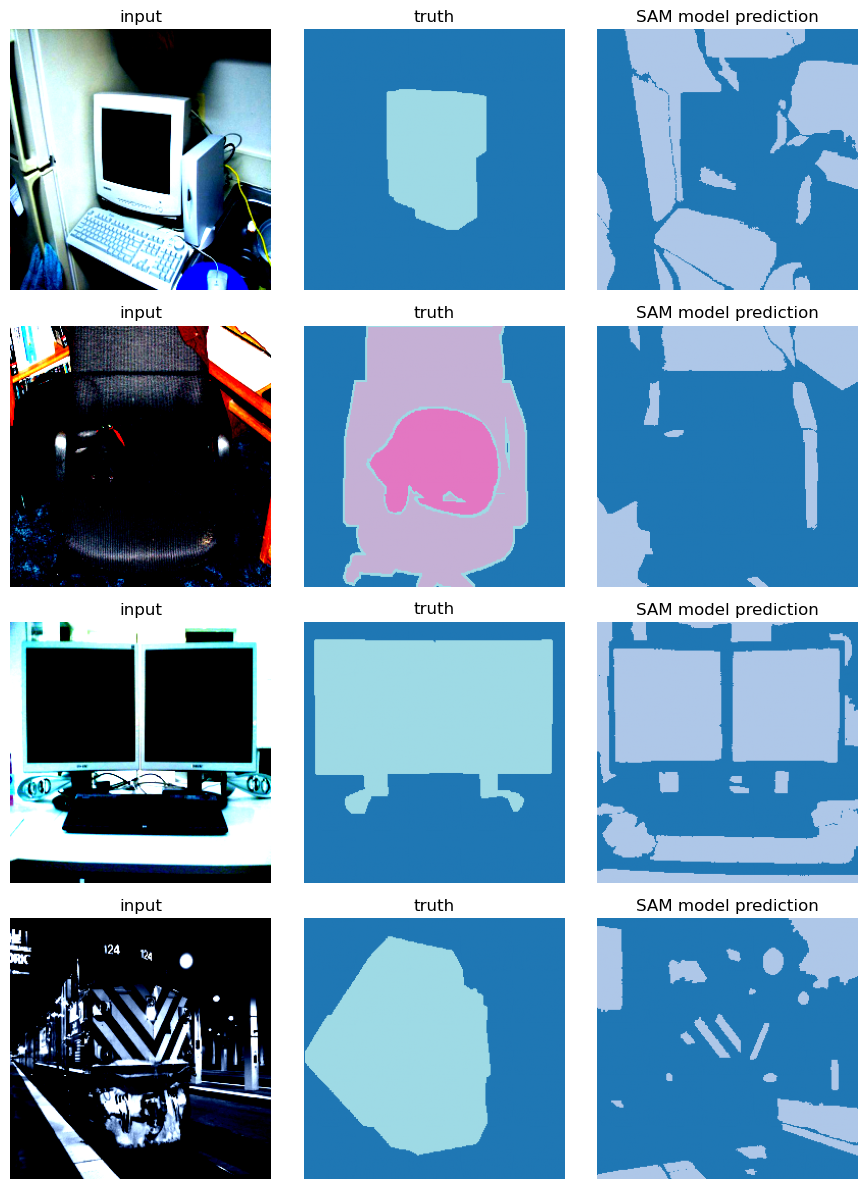

In [39]:
sam_cm = torch.zeros(2, 2, dtype=torch.int64, device=device)
sam_hd95 = []; count = 0
progress_bar = tqdm(total = 100)
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        y_true_sam = masks_batch.squeeze(1).numpy() # (B, H, W)
        for i in range(images_batch.size(0)):
            if count >= 100:
                break
            img = images_batch[i]
            true_np = y_true_sam[i]
            pred_bin = binary_mask(img)
            true_bin = np.zeros_like(true_np, dtype=np.uint8)
            true_bin[(true_np != 0) & true_np != 255] = 1
            y_true_tensor = torch.from_numpy(true_bin).to(device)
            y_pred_tensor = torch.from_numpy(pred_bin).to(device)
            sam_cm += compute_confusion_matrix(
                y_pred_tensor[y_true_tensor != 255],
                y_true_tensor[y_true_tensor != 255],
                2,
            )
            hd = compute_hd95(true_bin.astype(bool), pred_bin.astype(bool))
            sam_hd95.append(hd)
            count += 1
            progress_bar.update(1)
        if count >= 100:
            break
progress_bar.close()
sam_metrics = compute_metrics(sam_cm)
print("SAM mIoU:", sam_metrics["mean_iou"])
print("SAM Dice:", sam_metrics["mean_dice"])
print("SAM Pixel accuracy:", sam_metrics["pixel_accuracy"])
print("SAM HD95:", float(np.mean(sam_hd95)))
sam_imgs = []
sam_true = []
sam_pred = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        y_true_sam = masks_batch.squeeze(1).numpy()
        for i in range(images_batch.size(0)):
            if len(sam_imgs) >= 4:
                break
            img = images_batch[i]
            true_np = y_true_sam[i]
            pred_bin = binary_mask(img)
            sam_imgs.append(img.cpu())
            sam_true.append(true_np)
            sam_pred.append(pred_bin)
        if len(sam_imgs) >= 4:
            break
segmentation_map(sam_imgs, sam_true, sam_pred, "SAM model")

#### Implement ablation studies

U-Net model size ablation study: Model training

In [40]:
unet2_model = UNet(num_classes=NUM_CLASSES, base_channels=32).to(device)
unet2_optimizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-3)
unet2_loss_func = nn.CrossEntropyLoss(ignore_index=255)
for epoch in range(15):
    unet2_model.train()
    unet2_total_loss = 0.0
    print(f"Epoch {epoch+1}")
    for images_batch, masks_batch in tqdm(train_loader):
        images_batch = images_batch.to(device)
        masks_batch = masks_batch.squeeze(1).to(device).long()
        unet2_optimizer.zero_grad()
        unet2_loss = unet2_loss_func(unet2_model(images_batch), masks_batch)
        unet2_loss.backward()
        unet2_optimizer.step()
        unet2_total_loss += unet2_loss.item() * images_batch.size(0)
    unet2_avg_loss = unet2_total_loss / len(train_loader.dataset)
    print(f"U-Net (base_channels = 32) epoch {epoch+1}: train loss = {unet2_avg_loss:.4f}")

Epoch 1


100%|██████████| 52/52 [03:43<00:00,  4.29s/it]


U-Net (base_channels = 32) epoch 1: train loss = 2.7539
Epoch 2


100%|██████████| 52/52 [03:43<00:00,  4.29s/it]


U-Net (base_channels = 32) epoch 2: train loss = 1.9755
Epoch 3


100%|██████████| 52/52 [04:10<00:00,  4.82s/it]


U-Net (base_channels = 32) epoch 3: train loss = 1.4613
Epoch 4


100%|██████████| 52/52 [04:56<00:00,  5.70s/it]


U-Net (base_channels = 32) epoch 4: train loss = 1.2867
Epoch 5


100%|██████████| 52/52 [04:26<00:00,  5.12s/it]


U-Net (base_channels = 32) epoch 5: train loss = 1.2608
Epoch 6


100%|██████████| 52/52 [04:25<00:00,  5.11s/it]


U-Net (base_channels = 32) epoch 6: train loss = 1.2301
Epoch 7


100%|██████████| 52/52 [04:22<00:00,  5.05s/it]


U-Net (base_channels = 32) epoch 7: train loss = 1.2138
Epoch 8


100%|██████████| 52/52 [04:27<00:00,  5.14s/it]


U-Net (base_channels = 32) epoch 8: train loss = 1.2083
Epoch 9


100%|██████████| 52/52 [04:33<00:00,  5.26s/it]


U-Net (base_channels = 32) epoch 9: train loss = 1.1886
Epoch 10


100%|██████████| 52/52 [04:07<00:00,  4.75s/it]


U-Net (base_channels = 32) epoch 10: train loss = 1.1880
Epoch 11


100%|██████████| 52/52 [04:11<00:00,  4.84s/it]


U-Net (base_channels = 32) epoch 11: train loss = 1.1772
Epoch 12


100%|██████████| 52/52 [04:24<00:00,  5.08s/it]


U-Net (base_channels = 32) epoch 12: train loss = 1.1947
Epoch 13


100%|██████████| 52/52 [04:07<00:00,  4.76s/it]


U-Net (base_channels = 32) epoch 13: train loss = 1.1925
Epoch 14


100%|██████████| 52/52 [04:00<00:00,  4.62s/it]


U-Net (base_channels = 32) epoch 14: train loss = 1.1738
Epoch 15


100%|██████████| 52/52 [04:02<00:00,  4.66s/it]

U-Net (base_channels = 32) epoch 15: train loss = 1.1735


U-Net model size ablation study: Model evaluation

U-Net (base_channels = 32) mIoU: 0.03877196869006056
U-Net (base_channels = 32) Dice: 0.047570307608235905
U-Net (base_channels = 32) Pixel accuracy: 0.7277746382640533
U-Net (base_channels = 32) HD95: 122.59154929577464
U-Net (base_channels = 32) Per-class IoU and accuracy
0 background IoU: 0.7302857427761487 Accuracy: 0.976470318405881
1 aeroplane IoU: 0.0 Accuracy: 0.0
2 bicycle IoU: 0.0 Accuracy: 0.0
3 bird IoU: 0.0 Accuracy: 0.0
4 boat IoU: 0.0 Accuracy: 0.0
5 bottle IoU: 0.0 Accuracy: 0.0
6 bus IoU: 0.0 Accuracy: 0.0
7 car IoU: 0.0 Accuracy: 0.0
8 cat IoU: 0.0 Accuracy: 0.0
9 chair IoU: 0.0 Accuracy: 0.0
10 cow IoU: 0.0 Accuracy: 0.0
11 diningtable IoU: 0.0 Accuracy: 0.0
12 dog IoU: 0.0 Accuracy: 0.0
13 horse IoU: 0.0 Accuracy: 0.0
14 motorbike IoU: 0.0 Accuracy: 0.0
15 person IoU: 0.08392559971512316 Accuracy: 0.11691843550249151
16 pottedplant IoU: 0.0 Accuracy: 0.0
17 sheep IoU: 0.0 Accuracy: 0.0
18 sofa IoU: 0.0 Accuracy: 0.0
19 train IoU: 0.0 Accuracy: 0.0
20 tvmonitor IoU: 

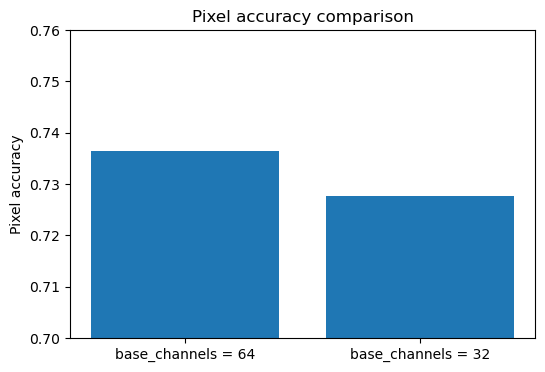

In [53]:
unet2_model.eval()
unet2_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64, device=device)
unet2_hd95 = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_small = masks_batch.squeeze(1).to(device).long()
        y_pred_small = torch.argmax(unet2_model(images_batch), dim=1)
        unet2_cm += compute_confusion_matrix(
            y_pred_small[y_true_small != 255],
            y_true_small[y_true_small != 255],
            NUM_CLASSES
        )
        for b in range(images_batch.size(0)):
            true_np = y_true_small[b].cpu().numpy()
            pred_np = y_pred_small[b].cpu().numpy()
            true_foreground = (true_np != 0) & (true_np != 255)
            pred_foreground = pred_np != 0
            hd = compute_hd95(true_foreground, pred_foreground)
            unet2_hd95.append(hd)
unet2_metrics = compute_metrics(unet2_cm)
print("U-Net (base_channels = 32) mIoU:", unet2_metrics["mean_iou"])
print("U-Net (base_channels = 32) Dice:", unet2_metrics["mean_dice"])
print("U-Net (base_channels = 32) Pixel accuracy:", unet2_metrics["pixel_accuracy"])
print("U-Net (base_channels = 32) HD95:", float(np.mean(unet2_hd95)))
print("U-Net (base_channels = 32) Per-class IoU and accuracy")
for i in range(NUM_CLASSES):
    print(
        i,
        VOC_CLASSES[i],
        "IoU:",
        float(unet2_metrics["per_class_iou"][i]),
        "Accuracy:",
        float(unet2_metrics["per_class_acc"][i]),
    )
plt.figure(figsize=(6,4))
plt.bar(["base_channels = 64", "base_channels = 32"], [unet_metrics["pixel_accuracy"], unet2_metrics["pixel_accuracy"]])
plt.ylabel("Pixel accuracy")
plt.title("Pixel accuracy comparison")
plt.ylim(0.70, 0.76)
plt.show()

U-Net model with weighted class: Class weights computation

In [52]:
def compute_weights(loader, num_classes=NUM_CLASSES):
    counts = torch.zeros(num_classes)
    for imgs, masks in loader:
        masks = masks.squeeze(1)  # (B H W)
        masks = masks[masks != 255]  # ignore pixels
        counts += torch.bincount(masks.flatten(), minlength=num_classes)
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * num_classes  # normalize
    return weights.float()
class_weights = compute_weights(train_loader, NUM_CLASSES).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.0108, 1.5893, 1.7555, 0.9555, 1.6330, 1.0803, 0.3852, 1.0270, 0.4093,
        0.6904, 0.9798, 0.5815, 0.5326, 0.8916, 0.9675, 0.0845, 2.4391, 3.3080,
        0.4541, 0.6389, 0.5861])


U-Net model with weighted class: Model training

In [ ]:
unet3_model = UNet(num_classes=NUM_CLASSES, base_channels=64).to(device)
unet3_optimizer = torch.optim.Adam(unet3_model.parameters(), lr=1e-3)
unet3_loss_func = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)    # Replace default weights with default weights
for epoch in range(15):
    unet3_model.train()
    unet3_total_loss = 0.0
    print(f"Epoch {epoch+1}")
    for images_batch, masks_batch in tqdm(train_loader):
        images_batch = images_batch.to(device)
        masks_batch = masks_batch.squeeze(1).to(device).long()
        unet3_optimizer.zero_grad()
        unet3_loss = unet3_loss_func(unet3_model(images_batch), masks_batch)
        unet3_loss.backward()
        unet3_optimizer.step()
        unet3_total_loss += unet3_loss.item() * images_batch.size(0)
    unet3_avg_loss = unet3_total_loss / len(train_loader.dataset)
    print(f"U-Net epoch {epoch+1}: train loss = {unet3_avg_loss:.4f}")

Epoch 1


100%|██████████| 52/52 [02:45<00:00,  3.17s/it]


U-Net epoch 1: train loss = 3.1004
Epoch 2


100%|██████████| 52/52 [02:43<00:00,  3.14s/it]


U-Net epoch 2: train loss = 3.0048
Epoch 3


100%|██████████| 52/52 [02:44<00:00,  3.17s/it]


U-Net epoch 3: train loss = 2.9432
Epoch 4


100%|██████████| 52/52 [02:43<00:00,  3.14s/it]


U-Net epoch 4: train loss = 2.9093
Epoch 5


100%|██████████| 52/52 [02:44<00:00,  3.16s/it]


U-Net epoch 5: train loss = 2.8946
Epoch 6


100%|██████████| 52/52 [02:43<00:00,  3.15s/it]


U-Net epoch 6: train loss = 2.8588
Epoch 7


100%|██████████| 52/52 [02:44<00:00,  3.16s/it]


U-Net epoch 7: train loss = 2.8614
Epoch 8


100%|██████████| 52/52 [02:44<00:00,  3.17s/it]


U-Net epoch 8: train loss = 2.8461
Epoch 9


100%|██████████| 52/52 [02:44<00:00,  3.17s/it]


U-Net epoch 9: train loss = 2.8083
Epoch 10


100%|██████████| 52/52 [02:43<00:00,  3.14s/it]


U-Net epoch 10: train loss = 2.7999
Epoch 11


100%|██████████| 52/52 [02:46<00:00,  3.19s/it]


U-Net epoch 11: train loss = 2.7926
Epoch 12


100%|██████████| 52/52 [02:44<00:00,  3.16s/it]


U-Net epoch 12: train loss = 2.7810
Epoch 13


100%|██████████| 52/52 [02:43<00:00,  3.15s/it]


U-Net epoch 13: train loss = 2.7369
Epoch 14


100%|██████████| 52/52 [02:44<00:00,  3.17s/it]


U-Net epoch 14: train loss = 2.7600
Epoch 15


100%|██████████| 52/52 [02:44<00:00,  3.16s/it]

U-Net epoch 15: train loss = 2.7342


U-Net model with weighted class: Model evaluation

U-Net (with weighted class) mIoU: 0.026969808340429658
U-Net (with weighted class) Dice: 0.048293486092626035
U-Net (with weighted class) Pixel accuracy: 0.2052820332611188
U-Net (with weighted class) HD95: 0.0
U-Net (with weighted class) Per-class IoU and accuracy
0 background IoU: 0.2394190933607915 Accuracy: 0.24894231670968092
1 aeroplane IoU: 0.01684258677238207 Accuracy: 0.08925479461083322
2 bicycle IoU: 0.006713384393244499 Accuracy: 0.29738936976293184
3 bird IoU: 0.0044123871784218826 Accuracy: 0.008162167719885665
4 boat IoU: 0.004803657330009346 Accuracy: 0.011736267400163813
5 bottle IoU: 0.015210127309945016 Accuracy: 0.01915246569142037
6 bus IoU: 0.012168126661893392 Accuracy: 0.015768759839069543
7 car IoU: 0.010329410073829794 Accuracy: 0.13375139071494513
8 cat IoU: 0.007820682541958992 Accuracy: 0.009576012446860105
9 chair IoU: 0.004951529957051928 Accuracy: 0.006977292238282545
10 cow IoU: 0.0007980845969666541 Accuracy: 0.0008720333766492784
11 diningtable IoU: 0

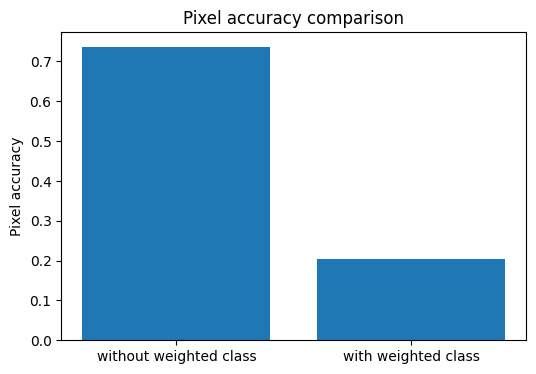

In [ ]:
unet3_model.eval()
unet3_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64, device=device)
unet3_hd95 = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_small = masks_batch.squeeze(1).to(device).long()
        y_pred_small = torch.argmax(unet3_model(images_batch), dim=1)
        unet3_cm += compute_confusion_matrix(
            y_pred_small[y_true_small != 255],
            y_true_small[y_true_small != 255],
            NUM_CLASSES
        )
        for b in range(images_batch.size(0)):
            true_np = y_true_small[b].cpu().numpy()
            pred_np = y_pred_small[b].cpu().numpy()
            true_foreground = (true_np != 0) & (true_np != 255)
            pred_foreground = pred_np != 0
            hd = compute_hd95(true_foreground, pred_foreground)
            unet3_hd95.append(hd)
unet3_metrics = compute_metrics(unet3_cm)
print("U-Net (with weighted class) mIoU:", unet3_metrics["mean_iou"])
print("U-Net (with weighted class) Dice:", unet3_metrics["mean_dice"])
print("U-Net (with weighted class) Pixel accuracy:", unet3_metrics["pixel_accuracy"])
print("U-Net (with weighted class) HD95:", float(np.mean(unet3_hd95)))
print("U-Net (with weighted class) Per-class IoU and accuracy")
for i in range(NUM_CLASSES):
    print(
        i,
        VOC_CLASSES[i],
        "IoU:",
        float(unet3_metrics["per_class_iou"][i]),
        "Accuracy:",
        float(unet3_metrics["per_class_acc"][i]),
    )
plt.figure(figsize=(6,4))
plt.bar(["without weighted class", "with weighted class"], [0.7364858733169789, unet3_metrics["pixel_accuracy"]])
plt.ylabel("Pixel accuracy")
plt.title("Pixel accuracy comparison")
plt.show()

DeepLabV3 pretraining ablation study: Model training

In [42]:
deeplab2_model = models.segmentation.deeplabv3_resnet50(weights=None)
deeplab2_model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
deeplab2_model.to(device)
deeplab2_optimizer = torch.optim.Adam(deeplab2_model.parameters(), lr=1e-4)
deeplab2_loss_func = nn.CrossEntropyLoss(ignore_index=255)
for epoch in range(10):
    deeplab2_model.train()
    deeplab2_total_loss = 0.0
    print(f"Epoch {epoch+1}")
    for images_batch, masks_batch in tqdm(train_loader):
        images_batch = images_batch.to(device)
        masks_batch = masks_batch.squeeze(1).to(device).long()
        deeplab2_optimizer.zero_grad()
        deeplab2_loss = deeplab2_loss_func(deeplab2_model(images_batch)["out"], masks_batch)
        deeplab2_loss.backward()
        deeplab2_optimizer.step()
        deeplab2_total_loss += deeplab2_loss.item() * images_batch.size(0)
    deeplab2_avg_loss = deeplab2_total_loss / len(train_loader.dataset)
    print(f"DeepLab (scratch) epoch {epoch+1}: train loss = {deeplab2_avg_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/xu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.4MB/s]


Epoch 1


100%|██████████| 52/52 [11:48<00:00, 13.63s/it]


DeepLab (scratch) epoch 1: train loss = 2.2549
Epoch 2


100%|██████████| 52/52 [11:50<00:00, 13.66s/it]


DeepLab (scratch) epoch 2: train loss = 1.3905
Epoch 3


100%|██████████| 52/52 [12:12<00:00, 14.08s/it]


DeepLab (scratch) epoch 3: train loss = 1.0891
Epoch 4


100%|██████████| 52/52 [13:37<00:00, 15.72s/it]


DeepLab (scratch) epoch 4: train loss = 0.8487
Epoch 5


100%|██████████| 52/52 [13:02<00:00, 15.04s/it]


DeepLab (scratch) epoch 5: train loss = 0.7030
Epoch 6


100%|██████████| 52/52 [13:24<00:00, 15.47s/it]


DeepLab (scratch) epoch 6: train loss = 0.5367
Epoch 7


100%|██████████| 52/52 [13:49<00:00, 15.96s/it]


DeepLab (scratch) epoch 7: train loss = 0.4424
Epoch 8


100%|██████████| 52/52 [12:37<00:00, 14.57s/it]


DeepLab (scratch) epoch 8: train loss = 0.3857
Epoch 9


100%|██████████| 52/52 [12:21<00:00, 14.26s/it]


DeepLab (scratch) epoch 9: train loss = 0.3011
Epoch 10


100%|██████████| 52/52 [12:42<00:00, 14.66s/it]

DeepLab (scratch) epoch 10: train loss = 0.2626


DeepLabV3 pretraining ablation study: Model evaluation

DeepLab (scratch) mIoU: 0.4185724913553968
DeepLab (scratch) Dice: 0.5568405040989184
DeepLab (scratch) Pixel accuracy: 0.8577764667904181
DeepLab (scratch) HD95: 8.413145539906104
DeepLab (scratch) Per-class IoU and accuracy
0 background IoU: 0.880508197910785 Accuracy: 0.9438346319922595
1 aeroplane IoU: 0.5604409266085392 Accuracy: 0.6690522913534828
2 bicycle IoU: 0.24016054109712137 Accuracy: 0.8590746341263981
3 bird IoU: 0.7274665740574909 Accuracy: 0.8283730237186675
4 boat IoU: 0.2571692334741187 Accuracy: 0.2925731432853337
5 bottle IoU: 0.5568473468307228 Accuracy: 0.7656462072074112
6 bus IoU: 0.47234112647277765 Accuracy: 0.9404582823154887
7 car IoU: 0.5403568030034717 Accuracy: 0.6375139071501593
8 cat IoU: 0.6462694883835822 Accuracy: 0.9249054442003851
9 chair IoU: 0.10988164122449 Accuracy: 0.14400659854887135
10 cow IoU: 0.33028007400865145 Accuracy: 0.7111774160448061
11 diningtable IoU: 0.33371177287559795 Accuracy: 0.3901451635023338
12 dog IoU: 0.5030032342519195

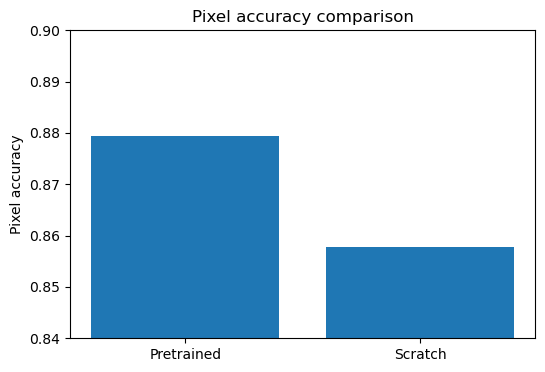

In [54]:
deeplab2_model.eval()
deeplab2_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int64, device=device)
deeplab2_hd95 = []
with torch.no_grad():
    for images_batch, masks_batch in val_loader:
        images_batch = images_batch.to(device)
        y_true_scratch = masks_batch.squeeze(1).to(device).long()
        y_pred_scratch = torch.argmax(deeplab2_model(images_batch)["out"], dim=1)
        deeplab2_cm += compute_confusion_matrix(
            y_pred_scratch[y_true_scratch != 255],
            y_true_scratch[y_true_scratch != 255],
            NUM_CLASSES
        )
        for b in range(images_batch.size(0)):
            true_np = y_true_scratch[b].cpu().numpy()
            pred_np = y_pred_scratch[b].cpu().numpy()
            true_foreground = (true_np != 0) & (true_np != 255)
            pred_foreground = pred_np != 0
            hd = compute_hd95(true_foreground, pred_foreground)
            deeplab2_hd95.append(hd)
deeplab2_metrics = compute_metrics(deeplab2_cm)
print("DeepLab (scratch) mIoU:", deeplab2_metrics["mean_iou"])
print("DeepLab (scratch) Dice:", deeplab2_metrics["mean_dice"])
print("DeepLab (scratch) Pixel accuracy:", deeplab2_metrics["pixel_accuracy"])
print("DeepLab (scratch) HD95:", float(np.mean(deeplab2_hd95)))
print("DeepLab (scratch) Per-class IoU and accuracy")
for i in range(NUM_CLASSES):
    print(
        i,
        VOC_CLASSES[i],
        "IoU:",
        float(deeplab2_metrics["per_class_iou"][i]),
        "Accuracy:",
        float(deeplab2_metrics["per_class_acc"][i]),
    )
plt.figure(figsize=(6,4))
plt.bar(["Pretrained", "Scratch"], [deeplab_metrics["pixel_accuracy"], deeplab2_metrics["pixel_accuracy"]])
plt.ylabel("Pixel accuracy")
plt.title("Pixel accuracy comparison")
plt.ylim(0.84, 0.90)
plt.show()